# Predicting Flu Vaccination: An Introduction to Machine Learning

This is a tutorial for the DrivenData Challenge at Good Tech Fest 2020. We will be working on ["Flu Shot Learning,"](https://www.drivendata.org/competitions/66/flu-shot-learning/) a practice machine learning competition on DrivenData. 

This notebook is adapted from the [benchmark walkthrough blog post](https://www.drivendata.co/blog/predict-flu-vaccine-data-benchmark/) for the competition. 

NC: This VERSION of the notebook focuses on categorical variables ONLY.

---

Pandemics have never taken center stage in the way they have this year with COVID-19. Vaccines are a key public health measure used to fight infectious diseases. Vaccines provide immunization for individuals, and enough immunization in a community can further reduce the spread of diseases through "herd immunity".

As of the writing of this post, vaccines for COVID-19 are still under development and not yet available. We will instead look at a recent historical pandemic, also of a deadly respiratory disease: the 2009 H1N1 influenza pandemic. The 2009 H1N1 flu virus, also called "swine flu," first appeared in the spring of 2009 and quickly spread across the world. 

Vaccines for H1N1 were first publicly available in the United States in October 2009, when the United States government began a vaccination campaign. We will look at data from the National 2009 H1N1 Flu Survey collected to monitor vaccination rates during that campaign. This phone survey asked people whether they had received H1N1 and seasonal flu vaccines, in conjunction with information they shared about their lives, opinions, and behaviors. A better understanding of how these characteristics have been associated with personal vaccination patterns may provide guidance for future public health efforts.

In this post, we'll walk through the competition. We will show you how to load the data and do a quick exploratory analysis. Then, we will train a simple model, make some predictions, and then submit those predictions to the competition.

## Loading the data

On the [data download page](https://www.drivendata.org/competitions/66/flu-shot-learning/data/), we provide everything you need to get started. **Note that you'll need to register for the competition in order to see this page.** 

- **Training Features**: These are the input variables that your model will use to predict the probability that people received H1N1 flu and seasonal flu vaccines. There are 35 feature columns in total, each a response to a survey question. These questions cover several different topics, such as whether people observed safe behavioral practices, their opinions about the diseases and the vaccines, and their demographics. Check out the [problem description](https://www.drivendata.org/competitions/66/flu-shot-learning/page/211/) page for more information. 
- **Training Labels**: These are the labels corresponding to the observations in the training features. There are two target variables: `h1n1_vaccine` and `seasonal_vaccine`. Both are binary variables, with 1 indicating that a person received the respective flu vaccine and 0 indicating that a person did not receive the respective flu vaccine.
- **Test Features**: These are the features for observations that you will use to generate predictions after training a model. We don't give you the labels for these samples—it's up to you to generate them.
- **Submission Format**: This file serves as an example for how to format your submission. It contains the index and columns for our submission prediction. The two target variable columns are filled with 0.5 as an example. Your submission to the leaderboard must be in this exact format (with different prediction values) in order to be scored successfully!

Let's start by importing the libraries we'll need to load and explore the data.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 100) # Display more dataframe columns in Jupyter

We'll use the `pathlib` base library from Python to manipulate file paths. It's a really easy way to deal with paths in Python. 

### Optional: Familiarise with pathlib

In [2]:
Path.cwd()

WindowsPath('C:/Users/Nat Coutts/repoGoodTech/flu-shot-learning-tutorial/notebooks')

In [3]:
Path.home()

WindowsPath('C:/Users/Nat Coutts')

In [4]:
Path().absolute().parent

WindowsPath('C:/Users/Nat Coutts/repoGoodTech/flu-shot-learning-tutorial')

### Continue with tutorial

In [5]:
# At first Nat set a static path, because she thought pathlib in Windows changes the / to \. The code can't read it without the slash being a forward slash
#Jay Qi's code: 
DATA_PATH = Path().absolute().parent / "data" / "raw"
#DATA_PATH = Path().absolute().parent.joinpath("data", "raw")
#DATA_PATH = pathlib.PureWindowsPath(Path().absolute().parent / "data" / "raw")
#DATA_PATH = "C:/Users/Nat Coutts/repoGoodTech/flu-shot-learning-tutorial/data/raw"

print(DATA_PATH)

C:\Users\Nat Coutts\repoGoodTech\flu-shot-learning-tutorial\data\raw


As part of the [Cookiecutter Data Science](https://drivendata.github.io/cookiecutter-data-science/) project structure, we recommend keeping data in a `data/` directory, and further having a `data/raw/` subdirectory where the raw data lives unchanging. 

Next, we can load the datasets and begin taking a look. 

In [6]:
# Nat had to set a static path, because pathlib in Windows changes the / to \. The code can't read it without the slash being a forward slash
features_df = pd.read_csv(
    DATA_PATH / "training_set_features.csv", 
    #"C:/Users/Nat Coutts/repoGoodTech/flu-shot-learning-tutorial/data/raw/training_set_features.csv",
    index_col="respondent_id"
)
labels_df = pd.read_csv(
    DATA_PATH / "training_set_labels.csv", 
    #"C:/Users/Nat Coutts/repoGoodTech/flu-shot-learning-tutorial/data/raw/training_set_labels.csv",
    index_col="respondent_id"
)

In [7]:
# to follow Jason Brownlee's tutorial, split labels into H1N1 and seasonal flu targets
labels_df_H1N1 = labels_df['h1n1_vaccine']
labels_df_seasonal = labels_df['seasonal_vaccine']

In [8]:
print("features_df.shape", features_df.shape)
features_df.head()

features_df.shape (26707, 35)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


Each row is a person who was a survey respondent. The columns are the feature values corresponding to those people. We have 26,707 observations and 35 features.

In [9]:
features_df.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

Now let's look at the labels.

In [10]:
print("labels_df.shape", labels_df.shape)
labels_df.head()

labels_df.shape (26707, 2)


,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0


In [11]:
print("labels_df_H1N1.shape", labels_df_H1N1.shape)
labels_df_H1N1.head()

labels_df_H1N1.shape (26707,)


respondent_id
0    0
1    0
2    0
3    0
4    0
Name: h1n1_vaccine, dtype: int64

In [12]:
print("labels_df_seasonal.shape", labels_df_seasonal.shape)
labels_df_seasonal.head()

labels_df_seasonal.shape (26707,)


respondent_id
0    0
1    1
2    0
3    1
4    0
Name: seasonal_vaccine, dtype: int64

We have the same 26,707 observations, and two target variables that we have labels for.

Let's double-check that the rows between the features and the labels match up. We don't want to have the wrong labels. Numpy's [`assert_array_equal`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.testing.assert_array_equal.html) will error if the two arrays—the row indices of the two data frames—don't match up.

In [13]:
np.testing.assert_array_equal(features_df.index.values, labels_df.index.values)

The assertion ran, and nothing happened. That's good, it means there is no problem. If the two index arrays were not the same, there would be an error.

## Exploring the data

In [14]:
# count the number of observations
labels_df.shape[0]

26707

In [15]:
# count the number of respondents that did not versus did get the H1N1 vaccine
labels_df['h1n1_vaccine'].value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

## Exploring the data visually

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

### Labels

Let's start by taking a look at our distribution of the two target variables.

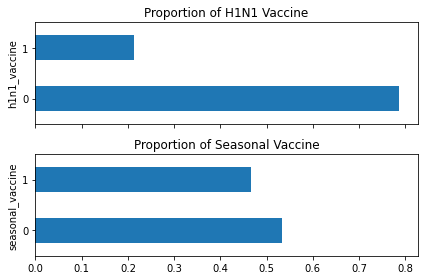

In [17]:
fig, ax = plt.subplots(2, 1, sharex=True)

n_obs = labels_df.shape[0]

(labels_df['h1n1_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of H1N1 Vaccine", ax=ax[0])
)
ax[0].set_ylabel("h1n1_vaccine")

(labels_df['seasonal_vaccine']
    .value_counts()
    .div(n_obs)
    .plot.barh(title="Proportion of Seasonal Vaccine", ax=ax[1])
)
ax[1].set_ylabel("seasonal_vaccine")

fig.tight_layout()

It looks like roughy half of people received the seasonal flu vaccine, but only about 20% of people received the H1N1 flu vaccine. In terms of class balance, we say that the seasonal flu vaccine target has balanced classes, but the H1N1 flu vaccine target has moderately imbalanced classes. 

Are the two target variables independent? Let's take a look.

In [18]:
pd.crosstab(
    labels_df["h1n1_vaccine"], 
    labels_df["seasonal_vaccine"], 
    margins=True,
    normalize=True
)

seasonal_vaccine,0,1,All
h1n1_vaccine,,,
0,0.497810,0.289737,0.787546
1,0.036582,0.175871,0.212454
All,0.534392,0.465608,1.000000


In [19]:
# Phi Coefficient is the same as Pearson for two binary variables
labels_df["h1n1_vaccine"].corr(labels_df["seasonal_vaccine"], method="pearson")

0.37714265306144684

These two variables have a [phi coefficient](https://en.wikipedia.org/wiki/Phi_coefficient) of 0.37, indicating a moderate positive correlation. We can see that in the cross-tabulation as well. Most people who got an H1N1 flu vaccine also got the seasonal flu vaccine. While a minority of people who got the seasonal vaccine got the H1N1 vaccine, they got the H1N1 vaccine at a higher rate than those who did not get the seasonal vaccine.

### Features

Next, let's take a look at our features. From the problem description page, we know that the feature variables are all categorical: a mix of binary, ordinal, and nominal features. Let's pick a few and see how the rates of vaccination may differ across the levels of the feature variables. 

First, let's combine our features and labels into one dataframe.

In [20]:
features_df

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN


In [21]:
labels_df

,h1n1_vaccine,seasonal_vaccine
respondent_id,,
0,0,0
1,0,1
2,0,0
3,0,1
4,0,0
...,...,...
26702,0,0
26703,0,0
26704,0,1


In [22]:
joined_df = features_df.join(labels_df)
print(joined_df.shape)

(26707, 37)


#### Prototyping a Plot

Next, let's see how the features are correlated with the target variables. We'll start with trying to visualize if there is simple bivariate correlation. If a feature is correlated with the target, we'd expect there to be different patterns of vaccination as you vary the values of the feature.

Jumping right to the right final visualization is hard. We can instead pick one feature and one target and work our way up to a prototype, before applying it to more features and both targets. We'll use `h1n1_concern`, the level of concern the person showed about the H1N1 flu, and `h1n1_vaccine` as a target variable.

First, we'll get the count of observations for each combination of those two variables.

In [23]:
counts = (joined_df[['h1n1_concern', 'h1n1_vaccine']]
              .groupby(['h1n1_concern', 'h1n1_vaccine'])
              .size()
              .unstack('h1n1_vaccine')
         )
counts

h1n1_vaccine,0,1
h1n1_concern,,
0.0,2849,447
1.0,6756,1397
2.0,8102,2473
3.0,3250,1341


It's hard to eyeball these raw numbers and see patterns clearly. Let's put this into a bar chart. We'll compare how the group sizes change as you vary `h1n1_concern`.

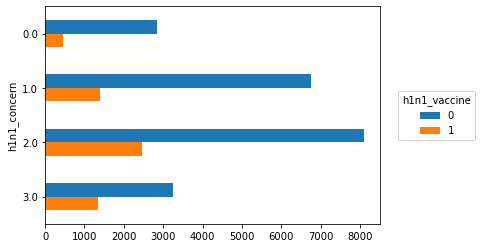

In [24]:
# To plot h1n1_vaccine as a separate series, 
# we pivot using unstack to make h1n1_vaccine into columns 
ax = counts.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center right', 
    bbox_to_anchor=(1.3, 0.5), 
    title='h1n1_vaccine'
)

Unfortunately, it's still hard to tell whether `h1n1_concern` levels show differences in someone's likelihood to get vaccinated. Since the two classes are imbalanced, we just see fewer vaccinated observations for every level of `h1n1_concern`. It swamps out any other trends that might exist.

Let's instead look at the **rate** of vaccination for each level of `h1n1_concern`. 

In [25]:
h1n1_concern_counts = counts.sum(axis='columns')
h1n1_concern_counts

h1n1_concern
0.0     3296
1.0     8153
2.0    10575
3.0     4591
dtype: int64

In [26]:
# here's why not to use crosstab: it does percentages of WHOLE data set, not each concern level (in this case)
pd.crosstab(
    joined_df["h1n1_concern"], 
    joined_df["h1n1_vaccine"], 
    margins=True,
    normalize=True
)

h1n1_vaccine,0,1,All
h1n1_concern,,,
0.0,0.107045,0.016795,0.123840
1.0,0.253842,0.052489,0.306331
2.0,0.304415,0.092918,0.397332
3.0,0.122112,0.050385,0.172497
All,0.787413,0.212587,1.000000


In [27]:
props = counts.div(h1n1_concern_counts, axis='index')
props

h1n1_vaccine,0,1
h1n1_concern,,
0.0,0.864381,0.135619
1.0,0.828652,0.171348
2.0,0.766147,0.233853
3.0,0.707907,0.292093


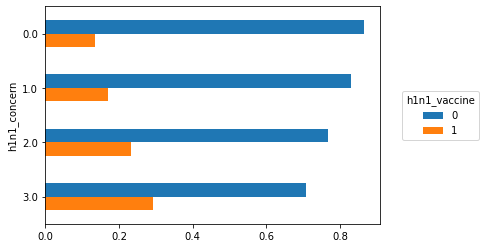

In [28]:
ax = props.plot.barh()
ax.invert_yaxis()
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

Now we have a clearer picture of what's happening! In this plot, each pair of blue (no vaccine) and orange (received vaccine) bars add up to 1.0. We can clearly see that even though most people don't get the H1N1 vaccine, they are more likely to if they have a higher level of concern. It looks like `h1n1_concern` will be a useful feature when we get to modeling.

Since every pair of bars adds up to 1.0 and we only have two bars, this is actually a good use case for a stacked bar chart, to make it even easier to read. 

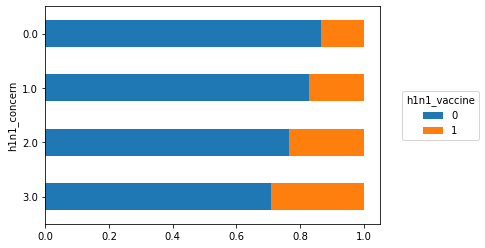

In [29]:
ax = props.plot.barh(stacked=True)
ax.invert_yaxis()
ax.legend(
    loc='center left', 
    bbox_to_anchor=(1.05, 0.5),
    title='h1n1_vaccine'
)

This is a more compact plot showing the same thing as before. 

#### Plotting more variables

Let's factor this code into a function so we can use it on more variables.

In [30]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (joined_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

Then, we'll loop through several columns and plot against both `h1n1_vaccine` and `seasonal_vaccine`.

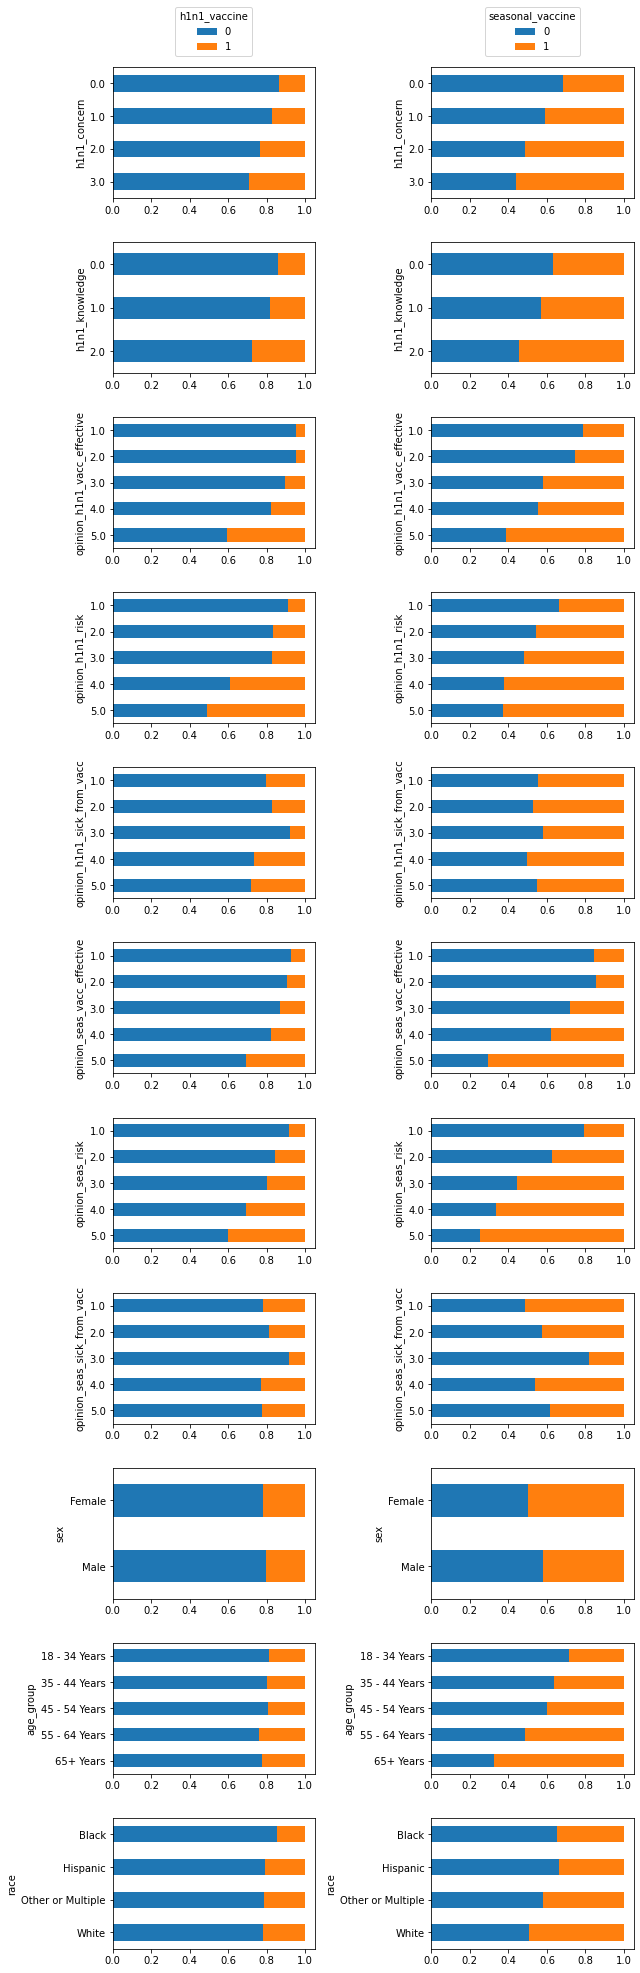

In [31]:
cols_to_plot = [
    'h1n1_concern',
    'h1n1_knowledge',
    'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk',
    'opinion_h1n1_sick_from_vacc',
    'opinion_seas_vacc_effective',
    'opinion_seas_risk',
    'opinion_seas_sick_from_vacc',
    'sex',
    'age_group',
    'race',
]

fig, ax = plt.subplots(len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5))
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(col, 'h1n1_vaccine', joined_df, ax=ax[idx, 0])
    vaccination_rate_plot(col, 'seasonal_vaccine', joined_df, ax=ax[idx, 1])
    
ax[0, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
ax[0, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')
fig.tight_layout()

It looks like the knowledge and opinion questions have pretty strong signal for both target variables. 

The demographic features have stronger correlation with `seasonal_vaccine`, but much less so far `h1n1_vaccine`. In particular, we interestingly see a strong correlation with `age_group` with the `seasonal_vaccine` but not with `h1n1_vaccine`. It appears that with seasonal flu, people act appropriately according to the fact that people [more impacted and have higher risk of flu-related complications with age](https://www.cdc.gov/flu/highrisk/index.htm). It turns out though that H1N1 flu has an interesting relationship with age: [even though older people have higher risk of complications, they were less likely to get infected!](https://www.cdc.gov/h1n1flu/surveillanceqa.htm#7) While we know anything about causality from this analysis, it seems like the risk factors ended up being reflected in the vaccination rates. 

### More columns to plot
NC: Eyeballing the graphs, it looks like income and education have an impact on H1N1 vaccine uptake. On top of that, unemployment had an impact on whether someone gets the seasonal flu vaccine (but not so much the H1N1 vaccine).

Other variables could be important as well, but those patterns are harder to see with the naked eye.

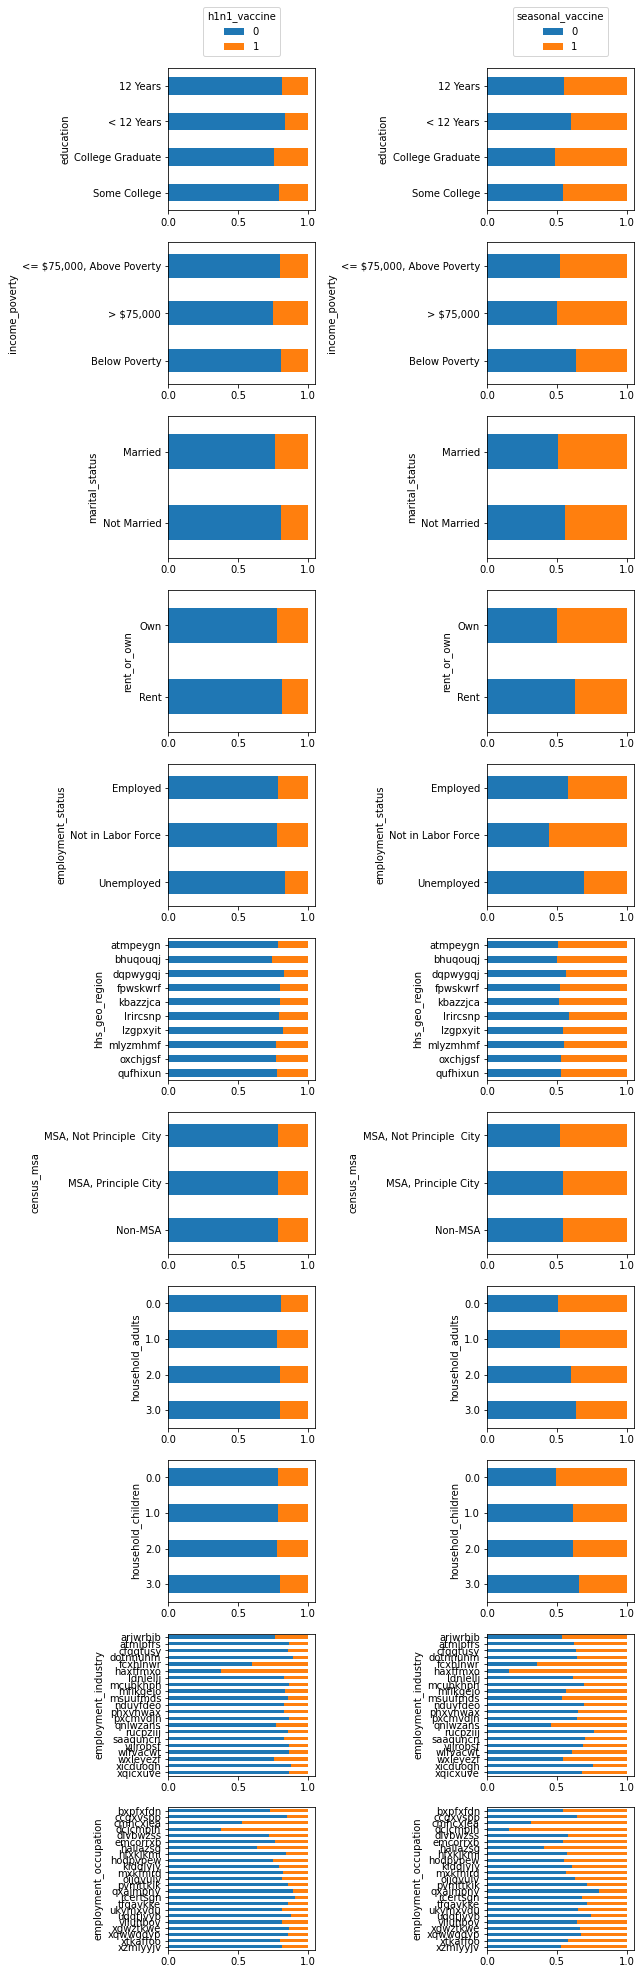

In [32]:
cols_to_plot = [
    'education',
    'income_poverty',
    'marital_status',
    'rent_or_own',
    'employment_status',
    'hhs_geo_region',
    'census_msa',
    'household_adults',
    'household_children',
    'employment_industry',
    'employment_occupation',
]

fig, ax = plt.subplots(len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5))
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(col, 'h1n1_vaccine', joined_df, ax=ax[idx, 0])
    vaccination_rate_plot(col, 'seasonal_vaccine', joined_df, ax=ax[idx, 1])
    
ax[0, 0].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine')
ax[0, 1].legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine')
fig.tight_layout()

## Building some models

Let's start working on training some models! We will be using logistic regression, a simple and fast linear model for classification problems. Logistic regression is a great model choice for a first-pass baseline model when starting out on a problem.

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_SEED = 6    # Set a random seed for reproducibility!

We will be using scikit-learn's logistic regression implementation. 

Standard logistic regression only works with numeric input for features. Since this is a benchmark, we're going to build simple models only using the numeric columns of our dataset. 

Categorical variables with non-numeric values take a little more preprocessing to prepare for many machine learning algorithms. We're not going to deal with them in this benchmark walkthrough, but there are many different ways to encode categorical variables into numeric values. Check out [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) and [ordinal encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) to get started if you're not familiar.

In [34]:
features_df.dtypes != "object"

h1n1_concern                    True
h1n1_knowledge                  True
behavioral_antiviral_meds       True
behavioral_avoidance            True
behavioral_face_mask            True
behavioral_wash_hands           True
behavioral_large_gatherings     True
behavioral_outside_home         True
behavioral_touch_face           True
doctor_recc_h1n1                True
doctor_recc_seasonal            True
chronic_med_condition           True
child_under_6_months            True
health_worker                   True
health_insurance                True
opinion_h1n1_vacc_effective     True
opinion_h1n1_risk               True
opinion_h1n1_sick_from_vacc     True
opinion_seas_vacc_effective     True
opinion_seas_risk               True
opinion_seas_sick_from_vacc     True
age_group                      False
education                      False
race                           False
sex                            False
income_poverty                 False
marital_status                 False
r

In [35]:
numeric_cols = features_df.columns[features_df.dtypes != "object"].values
print(numeric_cols)

['h1n1_concern' 'h1n1_knowledge' 'behavioral_antiviral_meds'
 'behavioral_avoidance' 'behavioral_face_mask' 'behavioral_wash_hands'
 'behavioral_large_gatherings' 'behavioral_outside_home'
 'behavioral_touch_face' 'doctor_recc_h1n1' 'doctor_recc_seasonal'
 'chronic_med_condition' 'child_under_6_months' 'health_worker'
 'health_insurance' 'opinion_h1n1_vacc_effective' 'opinion_h1n1_risk'
 'opinion_h1n1_sick_from_vacc' 'opinion_seas_vacc_effective'
 'opinion_seas_risk' 'opinion_seas_sick_from_vacc' 'household_adults'
 'household_children']


In [36]:
cat_cols = features_df.columns[features_df.dtypes == "object"].values
print(cat_cols)

['age_group' 'education' 'race' 'sex' 'income_poverty' 'marital_status'
 'rent_or_own' 'employment_status' 'hhs_geo_region' 'census_msa'
 'employment_industry' 'employment_occupation']


Ordinal variables: 
- age_group - Age group of respondent.
- education - Self-reported education level.
- income_poverty - Household annual income of respondent with respect to 2008 Census poverty thresholds.

Categorical: 
- race - Race of respondent.
- sex - Sex of respondent.
- marital_status - Marital status of respondent.
- rent_or_own - Housing situation of respondent.
- employment_status - Employment status of respondent.
- hhs_geo_region - Respondent's residence using a 10-region geographic classification defined by the U.S. Dept. of Health and Human Services. Values are represented as short random character strings.
- census_msa - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.
- employment_industry - Type of industry respondent is employed in. Values are represented as short random character strings.
- employment_occupation - Type of occupation of respondent. Values are represented as short random character strings.

There are two important data preprocessing steps before jumping to the logistic regression:

- **Scaling**: Transform all features to be on the same scale. This matters when using regularization, which we will discuss in the next section. We will use [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), also known as Z-score scaling. This scales and shifts features so that they have zero mean and unit variance. 
- **NA Imputation**: Logistic regression does not handle NA values. We will use median imputation, which fills missing values with the median from the training data, implemented with [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html). 

We are also going to start using Scikit-Learn's built-in composition functionality to encapsulate everything into a pipeline. Building pipelines is a best practice for building machine learning models. Among [other benefits](https://scikit-learn.org/stable/modules/compose.html), it makes it easy to reuse on new data (such as our test data).

In the block below, we're going to first chain together the preprocessing steps (scaling and imputing) into one pipeline object `numeric_preprocessing_steps`. Then, we use that with Scikit-Learn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), which is a convenient way to grab columns out of a pandas data frame and then apply a specified transformer. 

If we wanted to do other transformations on other columns, such as encoding our non-numeric columns, that would be additional entries to the list in the `transformers` argument of `ColumnTransformer`. 

#### The order of age_groups and income_poverty are incorrect. This needed to be fixed
https://towardsdatascience.com/preprocessing-with-sklearn-a-complete-and-comprehensive-guide-670cb98fcfb9

In [37]:
features_df['age_group'].value_counts()

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64

In [38]:
# to compare to feature after pre-processing
features_df['age_group'].head()

respondent_id
0    55 - 64 Years
1    35 - 44 Years
2    18 - 34 Years
3        65+ Years
4    45 - 54 Years
Name: age_group, dtype: object

In [39]:
# to compare to feature after pre-processing
features_df['age_group'].tail()

respondent_id
26702        65+ Years
26703    18 - 34 Years
26704    55 - 64 Years
26705    18 - 34 Years
26706        65+ Years
Name: age_group, dtype: object

In [40]:
age_cat = pd.Categorical(features_df['age_group'],
                        categories=['missing', '18 - 34 Years', '35 - 44 Years', '45 - 54 Years', 
                                    '55 - 64 Years', '65+ Years'],
                        ordered=True)

In [41]:
age_cat.fillna('missing')

[55 - 64 Years, 35 - 44 Years, 18 - 34 Years, 65+ Years, 45 - 54 Years, ..., 65+ Years, 18 - 34 Years, 55 - 64 Years, 18 - 34 Years, 65+ Years]
Length: 26707
Categories (6, object): [missing < 18 - 34 Years < 35 - 44 Years < 45 - 54 Years < 55 - 64 Years < 65+ Years]

In [42]:
age_labels, unique = pd.factorize(age_cat, sort=True)
features_df['age_group'] = age_labels
features_df['age_group'].head()

respondent_id
0    3
1    1
2    0
3    4
4    2
Name: age_group, dtype: int64

In [43]:
features_df['education'].value_counts()

College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64

In [44]:
# to compare to feature after pre-processing
features_df['education'].head()

respondent_id
0          < 12 Years
1            12 Years
2    College Graduate
3            12 Years
4        Some College
Name: education, dtype: object

In [45]:
# to compare to feature after pre-processing
features_df['education'].tail()

respondent_id
26702        Some College
26703    College Graduate
26704        Some College
26705        Some College
26706        Some College
Name: education, dtype: object

In [46]:
edu_cat = pd.Categorical(features_df['education'],
                        categories=['missing', '< 12 Years', '12 Years', 
                                    'Some College', 'College Graduate'],
                        ordered=True)

In [47]:
edu_cat.fillna('missing')

[< 12 Years, 12 Years, College Graduate, 12 Years, Some College, ..., Some College, College Graduate, Some College, Some College, Some College]
Length: 26707
Categories (5, object): [missing < < 12 Years < 12 Years < Some College < College Graduate]

In [48]:
edu_labels, unique = pd.factorize(edu_cat, sort=True)
features_df['education'] = edu_labels
features_df['education'].head()

respondent_id
0    0
1    1
2    3
3    1
4    2
Name: education, dtype: int64

### Income_poverty is my test patch: the tail contains a missing entry, so when I work out how to change its encoding, I can eyeball it below

In [49]:
features_df['income_poverty'].value_counts()

<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64

In [50]:
# to compare to feature after pre-processing
features_df['income_poverty'].head()

respondent_id
0                Below Poverty
1                Below Poverty
2    <= $75,000, Above Poverty
3                Below Poverty
4    <= $75,000, Above Poverty
Name: income_poverty, dtype: object

In [51]:
# to compare to feature after pre-processing
features_df['income_poverty'].tail()

respondent_id
26702    <= $75,000, Above Poverty
26703    <= $75,000, Above Poverty
26704                          NaN
26705    <= $75,000, Above Poverty
26706    <= $75,000, Above Poverty
Name: income_poverty, dtype: object

In [52]:
income_cat = pd.Categorical(features_df['income_poverty'],
                        categories=['missing', 'Below Poverty', '<= $75,000, Above Poverty', 
                                    '> $75,000'],
                        ordered=True)

In [53]:
income_cat.fillna('missing')

[Below Poverty, Below Poverty, <= $75,000, Above Poverty, Below Poverty, <= $75,000, Above Poverty, ..., <= $75,000, Above Poverty, <= $75,000, Above Poverty, missing, <= $75,000, Above Poverty, <= $75,000, Above Poverty]
Length: 26707
Categories (4, object): [missing < Below Poverty < <= $75,000, Above Poverty < > $75,000]

In [54]:
income_labels, unique = pd.factorize(income_cat, sort=True)
features_df['income_poverty'] = income_labels
features_df['income_poverty'].tail()

respondent_id
26702    1
26703    1
26704   -1
26705    1
26706    1
Name: income_poverty, dtype: int64

In [55]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

#### Checked back: the order of encoded variables and raw variables is the same for age, education and income

### Nominal Feature Preprocessing

In [56]:
features_df['race'].value_counts()

White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: race, dtype: int64

In [57]:
features_df['race'].head()

respondent_id
0    White
1    White
2    White
3    White
4    White
Name: race, dtype: object

In [58]:
features_df['race'].tail()

respondent_id
26702       White
26703       White
26704       White
26705    Hispanic
26706       White
Name: race, dtype: object

In [59]:
features_df['sex'].value_counts()

Female    15858
Male      10849
Name: sex, dtype: int64

In [60]:
features_df['sex'].head()

respondent_id
0    Female
1      Male
2      Male
3    Female
4    Female
Name: sex, dtype: object

In [61]:
features_df['sex'].tail()

respondent_id
26702    Female
26703      Male
26704    Female
26705    Female
26706      Male
Name: sex, dtype: object

In [62]:
features_df['marital_status'].value_counts()

Married        13555
Not Married    11744
Name: marital_status, dtype: int64

In [63]:
features_df['marital_status'].fillna('missing_marital_status',inplace=True)

In [64]:
features_df['marital_status'].head()

respondent_id
0    Not Married
1    Not Married
2    Not Married
3    Not Married
4        Married
Name: marital_status, dtype: object

In [65]:
features_df['marital_status'].tail()

respondent_id
26702    Not Married
26703    Not Married
26704    Not Married
26705        Married
26706        Married
Name: marital_status, dtype: object

In [66]:
features_df['rent_or_own'].value_counts()

Own     18736
Rent     5929
Name: rent_or_own, dtype: int64

In [67]:
features_df['rent_or_own'].fillna('missing_rental_status',inplace=True)

In [68]:
features_df['rent_or_own'].head()

respondent_id
0     Own
1    Rent
2     Own
3    Rent
4     Own
Name: rent_or_own, dtype: object

In [69]:
features_df['rent_or_own'].tail()

respondent_id
26702     Own
26703    Rent
26704     Own
26705    Rent
26706     Own
Name: rent_or_own, dtype: object

In [70]:
features_df['employment_status'].value_counts()

Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64

In [71]:
features_df['employment_status'].fillna('missing_employment_status',inplace=True)

In [72]:
features_df['employment_status'].head()

respondent_id
0    Not in Labor Force
1              Employed
2              Employed
3    Not in Labor Force
4              Employed
Name: employment_status, dtype: object

In [73]:
features_df['employment_status'].tail()

respondent_id
26702           Not in Labor Force
26703                     Employed
26704    missing_employment_status
26705                     Employed
26706           Not in Labor Force
Name: employment_status, dtype: object

In [74]:
features_df['hhs_geo_region'].value_counts()

lzgpxyit    4297
fpwskwrf    3265
qufhixun    3102
oxchjgsf    2859
kbazzjca    2858
bhuqouqj    2846
mlyzmhmf    2243
lrircsnp    2078
atmpeygn    2033
dqpwygqj    1126
Name: hhs_geo_region, dtype: int64

In [75]:
features_df['hhs_geo_region'].fillna('missing_hhs_geo_region',inplace=True)

In [76]:
features_df['hhs_geo_region'].head()

respondent_id
0    oxchjgsf
1    bhuqouqj
2    qufhixun
3    lrircsnp
4    qufhixun
Name: hhs_geo_region, dtype: object

In [77]:
features_df['hhs_geo_region'].tail()

respondent_id
26702    qufhixun
26703    lzgpxyit
26704    lzgpxyit
26705    lrircsnp
26706    mlyzmhmf
Name: hhs_geo_region, dtype: object

In [78]:
#census_msa
features_df['census_msa'].value_counts()

MSA, Not Principle  City    11645
MSA, Principle City          7864
Non-MSA                      7198
Name: census_msa, dtype: int64

In [79]:
features_df['census_msa'].fillna('census_msa',inplace=True)

In [80]:
features_df['census_msa'].head()

respondent_id
0                     Non-MSA
1    MSA, Not Principle  City
2    MSA, Not Principle  City
3         MSA, Principle City
4    MSA, Not Principle  City
Name: census_msa, dtype: object

In [81]:
features_df['census_msa'].tail()

respondent_id
26702                     Non-MSA
26703         MSA, Principle City
26704    MSA, Not Principle  City
26705                     Non-MSA
26706         MSA, Principle City
Name: census_msa, dtype: object

In [82]:
#employment_industry
features_df['employment_industry'].value_counts()

fcxhlnwr    2468
wxleyezf    1804
ldnlellj    1231
pxcmvdjn    1037
atmlpfrs     926
arjwrbjb     871
xicduogh     851
mfikgejo     614
vjjrobsf     527
rucpziij     523
xqicxuve     511
saaquncn     338
cfqqtusy     325
nduyfdeo     286
mcubkhph     275
wlfvacwt     215
dotnnunm     201
haxffmxo     148
msuufmds     124
phxvnwax      89
qnlwzans      13
Name: employment_industry, dtype: int64

In [83]:
features_df['employment_industry'].fillna('missing',inplace=True)

In [84]:
features_df['employment_industry'].head()

respondent_id
0     missing
1    pxcmvdjn
2    rucpziij
3     missing
4    wxleyezf
Name: employment_industry, dtype: object

In [85]:
features_df['employment_industry'].tail()

respondent_id
26702     missing
26703    fcxhlnwr
26704     missing
26705    fcxhlnwr
26706     missing
Name: employment_industry, dtype: object

In [86]:
#employment_occupation
features_df['employment_occupation'].value_counts()

xtkaffoo    1778
mxkfnird    1509
emcorrxb    1270
cmhcxjea    1247
xgwztkwe    1082
hfxkjkmi     766
qxajmpny     548
xqwwgdyp     485
kldqjyjy     469
uqqtjvyb     452
tfqavkke     388
ukymxvdu     372
vlluhbov     354
oijqvulv     344
ccgxvspp     341
bxpfxfdn     331
haliazsg     296
rcertsgn     276
xzmlyyjv     248
dlvbwzss     227
hodpvpew     208
dcjcmpih     148
pvmttkik      98
Name: employment_occupation, dtype: int64

In [87]:
features_df['employment_occupation'].fillna('missing',inplace=True)

In [88]:
features_df['employment_occupation'].head()

respondent_id
0     missing
1    xgwztkwe
2    xtkaffoo
3     missing
4    emcorrxb
Name: employment_occupation, dtype: object

In [89]:
features_df['employment_occupation'].tail()

respondent_id
26702     missing
26703    cmhcxjea
26704     missing
26705    haliazsg
26706     missing
Name: employment_occupation, dtype: object

In [90]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

### Pre-proceesing categorical variables

In [91]:
# regression models NEED dummy encoding - but must use the default handle_unknown='error' NOT handle_unknown='ignore'
# to avoid NaN issues, use 
#.fillna('missing_x_variable')

onehot = OneHotEncoder(dtype=np.int, drop='first', sparse=True)
processed = pd.DataFrame(onehot.fit_transform(features_df[['race','sex','marital_status', 'rent_or_own', 
                                                           'hhs_geo_region', 'census_msa', 'employment_industry','employment_occupation']])\
                        .toarray(),
                        columns=['Hispanic', 'Other or Multiple', 'White', 'Male', 'Not Married', 
                                 'Missing Marital Status', 'Rent', 'Missing Rental Status', 'geo-region_fpwskwrf', 
                                'geo-region_qufhixun', 'geo-region_oxchjgsf', 'geo-region_kbazzjca', 'geo-region_bhuqouqj', 
                                 'geo-region_mlyzmhmf', 'geo-region_lrircsnp', 'geo-region_atmpeygn', 'geo-region_dqpwygqj',
                                'MSA, Principle City', 'Non-MSA', 'fcxhlnwr', 'wxleyezf', 'ldnlellj', 'pxcmvdjn', 'atmlpfrs', 
                                 'arjwrbjb', 'xicduogh', 'mfikgejo', 'vjjrobsf', 'rucpziij', 'xqicxuve', 
                                 'saaquncn', 'cfqqtusy', 'nduyfdeo', 'mcubkhph', 'wlfvacwt', 'dotnnunm', 
                                 'haxffmxo', 'msuufmds', 'phxvnwax', 'qnlwzans','xtkaffoo', 'mxkfnird', 'emcorrxb', 'cmhcxjea', 'xgwztkwe', 'hfxkjkmi', 'qxajmpny', 'xqwwgdyp', 'kldqjyjy', 
'uqqtjvyb', 'tfqavkke', 'ukymxvdu', 'vlluhbov', 'oijqvulv', 'ccgxvspp', 'bxpfxfdn', 'haliazsg', 'rcertsgn',
'xzmlyyjv', 'dlvbwzss', 'hodpvpew', 'dcjcmpih', 'pvmttkik'])
# COLUMNS NEED TO BE SPECIFIED IN ALPHABETICAL ORDER
# Otherwise the column headers and the encoding won't match!

In [92]:
# COLUMNS NEED TO BE SPECIFIED IN ALPHABETICAL ORDER
# Otherwise the column headers and the encoding won't match!
# Thus geo-region and employment-industry are NOT coded right, but we don't know what those regions are anyway, so not going to try to fix it UNLESS it throws up an error for other variables as well
processed.head()

,Hispanic,Other or Multiple,White,Male,Not Married,Missing Marital Status,Rent,Missing Rental Status,geo-region_fpwskwrf,geo-region_qufhixun,geo-region_oxchjgsf,geo-region_kbazzjca,geo-region_bhuqouqj,geo-region_mlyzmhmf,geo-region_lrircsnp,geo-region_atmpeygn,geo-region_dqpwygqj,"MSA, Principle City",Non-MSA,fcxhlnwr,wxleyezf,ldnlellj,pxcmvdjn,atmlpfrs,arjwrbjb,xicduogh,mfikgejo,vjjrobsf,rucpziij,xqicxuve,saaquncn,cfqqtusy,nduyfdeo,mcubkhph,wlfvacwt,dotnnunm,haxffmxo,msuufmds,phxvnwax,qnlwzans,xtkaffoo,mxkfnird,emcorrxb,cmhcxjea,xgwztkwe,hfxkjkmi,qxajmpny,xqwwgdyp,kldqjyjy,uqqtjvyb,tfqavkke,ukymxvdu,vlluhbov,oijqvulv,ccgxvspp,bxpfxfdn,haliazsg,rcertsgn,xzmlyyjv,dlvbwzss,hodpvpew,dcjcmpih,pvmttkik
0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Combine ordinal and nominal variables into one dataframe ready for feature selection with chi-square

In [93]:
# add 'age_group' 'education' 'income_poverty' ordinal categories to processed dataframe, 
# ready for feature selection with chi-square
ord_var = features_df[['age_group']]#, 'education', 'income_poverty']]
ord_var.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   age_group  26707 non-null  int64
dtypes: int64(1)
memory usage: 1.7 MB


In [94]:
# MUST specify axis=1 to match the indeces of both dataframes
# ie. to create a dataframe of 26707 records, NOT 2x26707 records, use axis=1
processed_catVars = pd.concat([ord_var, processed], axis=1, sort=False)

### I'll be able to use the above pd.concat code to combine ALL the variables eventually too!

In [95]:
processed_catVars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 64 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   age_group               26707 non-null  int64
 1   Hispanic                26707 non-null  int32
 2   Other or Multiple       26707 non-null  int32
 3   White                   26707 non-null  int32
 4   Male                    26707 non-null  int32
 5   Not Married             26707 non-null  int32
 6   Missing Marital Status  26707 non-null  int32
 7   Rent                    26707 non-null  int32
 8   Missing Rental Status   26707 non-null  int32
 9   geo-region_fpwskwrf     26707 non-null  int32
 10  geo-region_qufhixun     26707 non-null  int32
 11  geo-region_oxchjgsf     26707 non-null  int32
 12  geo-region_kbazzjca     26707 non-null  int32
 13  geo-region_bhuqouqj     26707 non-null  int32
 14  geo-region_mlyzmhmf     26707 non-null  int32
 15  geo-region_lrircsnp

In [96]:
ord_var.head()

,age_group
respondent_id,
0,3
1,1
2,0
3,4
4,2


In [97]:
processed_catVars.head()

,age_group,Hispanic,Other or Multiple,White,Male,Not Married,Missing Marital Status,Rent,Missing Rental Status,geo-region_fpwskwrf,geo-region_qufhixun,geo-region_oxchjgsf,geo-region_kbazzjca,geo-region_bhuqouqj,geo-region_mlyzmhmf,geo-region_lrircsnp,geo-region_atmpeygn,geo-region_dqpwygqj,"MSA, Principle City",Non-MSA,fcxhlnwr,wxleyezf,ldnlellj,pxcmvdjn,atmlpfrs,arjwrbjb,xicduogh,mfikgejo,vjjrobsf,rucpziij,xqicxuve,saaquncn,cfqqtusy,nduyfdeo,mcubkhph,wlfvacwt,dotnnunm,haxffmxo,msuufmds,phxvnwax,qnlwzans,xtkaffoo,mxkfnird,emcorrxb,cmhcxjea,xgwztkwe,hfxkjkmi,qxajmpny,xqwwgdyp,kldqjyjy,uqqtjvyb,tfqavkke,ukymxvdu,vlluhbov,oijqvulv,ccgxvspp,bxpfxfdn,haliazsg,rcertsgn,xzmlyyjv,dlvbwzss,hodpvpew,dcjcmpih,pvmttkik
0,3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,4,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Adjust below pipeline so categorical variables are NOT dropped?
### OR concatenate processed and numeric variables into 1 dataframe!

In [98]:
# chain preprocessing into a Pipeline object
# Adjust below code for catVars - do we even need it, seeing the variables are already scaled and imputed??
'''numeric_preprocessing_steps = Pipeline([
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy='median'))
])

# create the preprocessor stage of final pipeline
preprocessor = ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, numeric_cols)
    ],
    remainder = "drop"
)'''


categorical_preprocessing_steps = Pipeline([
    ('minmaxscaler', MinMaxScaler())
])

# create the preprocessor stage of final pipeline
preprocessor = ColumnTransformer(
    transformers = [
        ("categorical", categorical_preprocessing_steps, processed_catVars)
    ],
    remainder = "drop"
)
        


'numeric_preprocessing_steps = Pipeline([\n    (\'standard_scaler\', StandardScaler()),\n    (\'simple_imputer\', SimpleImputer(strategy=\'median\'))\n])\n\n# create the preprocessor stage of final pipeline\npreprocessor = ColumnTransformer(\n    transformers = [\n        ("numeric", numeric_preprocessing_steps, numeric_cols)\n    ],\n    remainder = "drop"\n)'

Next, we're going to define our estimators. 

NC: In this version we've moved away from scikit-learn's default hyperparameters for [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) of L2 (a.k.a. Ridge) regularization with `C` value (inverse regularization strength) of 1 and used the Lasso technique instead. [Regularization](https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a) is useful because it reduces overfitting. Check out scikit-learn's documentation for [`LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) to read more. When building your own model, you may want to tune your hyperparameters using something like [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Because we have two labels we need to predict, we can use Scikit-Learn's [`MultiOutputClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html). This is a convenient shortcut for training two of the same type of model.

### Estimator

In [99]:
estimators = MultiOutputClassifier(
    estimator=LogisticRegression(penalty="l1", solver='liblinear')
)

JQ: We put the preprocessing and the estimator stages together into one Pipeline object, which gives us one interface to run data through. 
NC: Adjusted below code for catVars: we only need the estimator, the preprocessing is done above.

In [100]:
# Adjust below code for catVars: we only need the estimator
full_pipeline = Pipeline([
    #("preprocessor", preprocessor),
    ("estimators", estimators),
])

### Putting Together the Full Pipeline

We can see the full pipeline printed out below. Note the diagram is a new feature in scikit-learn v0.23.

In [101]:
from sklearn import set_config
set_config(display='diagram')

full_pipeline

Pipeline(steps=[('estimators',
                 MultiOutputClassifier(estimator=LogisticRegression(penalty='l1',
                                                                    solver='liblinear')))])

### Training and Evaluation - categorical variables

Finally, let's get ready to train and evaluate our model.

Let's split our available data into a training and evaluation set. (We're going to reserve "test set" to refer to the final predictions we upload to the platform.) We'll use a third of our data for evaluation.

Recall that earlier in our exploratory analysis, the `h1n1_vaccine` label classes were moderately imbalanced. Sometimes this can lead to lop-sided splits, which can lead to generalization problems with fitting and/or evaluating the model. We should have a large enough dataset that a randomly shuffled split should keep the same proportions, but we can use the `stratify` argument to enforce it.

### Split into train and test set
Having scaled and imputed NaNs, it's time to 
1. define estimators (in this case Lasso, instead of Ridge)
2. create a training & test set
3. specify whether it's the H1N1 or seasonal flu vaccine uptake that is the target variable!

In [102]:
# original code for numeric variables:
'''X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)'''

'X_train, X_eval, y_train, y_eval = train_test_split(\n    features_df,\n    labels_df,\n    test_size=0.33,\n    shuffle=True,\n    stratify=labels_df,\n    random_state=RANDOM_SEED\n)'

### Label is currently ONLY H1N1 vaccine uptake

In [103]:
# adjusted code for categorical variables, both input and target variables:
# circled back to specify whether it's the H1N1 or seasonal flu vaccine uptake that is the target variable! 
X_train, X_eval, y_train, y_eval = train_test_split(
    processed_catVars,
    labels_df_H1N1,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df_H1N1,
    random_state=RANDOM_SEED
)

In [104]:
y_eval

respondent_id
6071     0
13720    0
6496     0
13266    1
3870     0
        ..
16061    0
5036     0
312      0
23372    0
5430     0
Name: h1n1_vaccine, Length: 8814, dtype: int64

Now, let's train the model!

In [105]:
# Original code from Jay Qi tutorial
'''%%time

# Train model
full_pipeline.fit(X_train, y_train)

# Predict on evaluation set
# This competition wants probabilities, not labels
preds = full_pipeline.predict_proba(X_eval)
preds'''

'%%time\n\n# Train model\nfull_pipeline.fit(X_train, y_train)\n\n# Predict on evaluation set\n# This competition wants probabilities, not labels\npreds = full_pipeline.predict_proba(X_eval)\npreds'

### Code from Jason Brownlee tutorial
https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/

In [106]:
# feature selection. Adjusted JBL code, because JQ code used train v eval terminology instead of train v test
def select_features(X_train, y_train, X_eval):
	fs = SelectKBest(score_func=chi2, k='all')
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_eval_fs = fs.transform(X_eval)
	return X_train_fs, X_eval_fs, fs

ValueError: Input X must be non-negative. The negative inputs are where there were missing inputs, those were encoded as -1. :( 
I need to go back and work out if I can start the encoding at 0 instead of -1.

In [107]:
# feature selection
X_train_fs, X_eval_fs, fs = select_features(X_train, y_train, X_eval)

#### START OF UNNECESSARY SECTION? I NO LONGER KNOW IF THIS SECTION OF CODE IS REQUIRED AT ALL
I mistakenly followed these steps: https://machinelearningmastery.com/one-hot-encoding-for-categorical-data/, when I thought it was part of this: https://machinelearningmastery.com/feature-selection-with-categorical-data/#

In [108]:
# define the model
model = LogisticRegression()

In [109]:
# fit on the training set
model.fit(X_train, y_train)

G:\DS\envs\flu-shot-learning-tutorial\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [110]:
# predict on test set
yhat = model.predict(X_eval)

In [111]:
# evaluate predictions
accuracy = accuracy_score(y_eval, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 78.95


#### END OF UNNECESSARY SECTION? 

In [112]:
print("test_probas[0].shape", preds[0].shape)
print("test_probas[1].shape", preds[1].shape)

NameError: name 'preds' is not defined

This has given us back a list of two (n_obs, 2) arrays. The first array is for `h1n1_vaccine`, and the second array is for `seasonal_vaccine`. The two columns for each array are probabilities for class 0 and class 1 respectively. That means we want the second column (index 1) for each of the two arrays. Let's grab that and put it in a data frame.

In [ ]:
y_preds = pd.DataFrame(
    {
        "h1n1_vaccine": preds[0][:, 1],
        "seasonal_vaccine": preds[1][:, 1],
    },
    index = y_eval.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

This competition uses ROC AUC as the metric. Let's plot ROC curves and take a look. Unfortunately, scikit-learn's convenient [`plot_roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html) doesn't support multilabel, so we'll need to make the plot ourselves. 

In [ ]:
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('TPR')
    ax.set_xlabel('FPR')
    ax.set_title(
        f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
    )

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))

plot_roc(
    y_eval['h1n1_vaccine'], 
    y_preds['h1n1_vaccine'], 
    'h1n1_vaccine',
    ax=ax[0]
)
plot_roc(
    y_eval['seasonal_vaccine'], 
    y_preds['seasonal_vaccine'], 
    'seasonal_vaccine',
    ax=ax[1]
)
fig.tight_layout()

An AUC score of 0.5 is no better than random, and an AUC score of 1.0 is a perfect model. Both models look like they generally perform similarly. Our scores of around 0.83 are not great, but they're not bad either!

The competition metric is the average between these two AUC values. Scikit-learn's [`roc_auc_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) _does_ support multilabel, so we can use that directly.

In [ ]:
roc_auc_score(y_eval, y_preds)

Now that we have an idea of our performance, we'll want to retrain our model on the full dataset before generating our predictions on the test set.

In [ ]:
%%time 

full_pipeline.fit(processed_catVars, labels_df)

None   # So we don't print out the whole pipeline representation

## Generating the Predictions for the Test Set

Now that we've trained a model, let's make predictions on the test set. Again, for this competition, we want the **probabilities**, not the binary label predictions. We'll again use the `.predict_proba` method to get those.

In [ ]:
test_features_df = pd.read_csv(DATA_PATH / "test_set_features.csv", 
                               index_col="respondent_id")

In [ ]:
test_probas = full_pipeline.predict_proba(test_features_df)
test_probas

As before, this gives us back two arrays: one for `h1n1_vaccine`, and one for `seasonal_vaccine`. The two columns for each array are probabilities for class 0 and class 1 respectively. That means we want the second column (index 1) for each of the two arrays.

Let's read in the submission format file so we can put our predictions into it.

In [ ]:
# I'm letting this throw up an error at the moment because I don't want it to run the last few cells
# Need to download the submission_format.csv eventually
submission_df = pd.read_csv(DATA_PATH / "submission_format.csv", 
                            index_col="respondent_id")

In [ ]:
submission_df.head()

We want to replace those 0.5s and 0.7s with our predictions. First, make sure we have the rows in the same order by comparing the indices. Then, we can drop in the appropriate columns from our predicted probabilities. 

In [ ]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

# Save predictions to submission data frame
submission_df["h1n1_vaccine"] = test_probas[0][:, 1]
submission_df["seasonal_vaccine"] = test_probas[1][:, 1]

submission_df.head()

In [ ]:
OUTPUT_DATA_PATH = Path().absolute().parent / "data" / "processed" / "Submission_NC_20200702.csv"
print(OUTPUT_DATA_PATH)

In [ ]:
submission_df.to_csv(OUTPUT_DATA_PATH, index=True)

In [ ]:
!head $OUTPUT_DATA_PATH

### Submit to the Leaderboard

We can then head over to the competition [submissions page](https://www.drivendata.org/competitions/66/flu-shot-learning/submissions/) to submit the predictions.

<div align="center">
    <img src="https://drivendata-public-assets.s3.amazonaws.com/flu-vaccines-benchmark-submission.png" width=500/>
</div>

Done!